<center><h1>  Synthetic Experiments    </h1></center>

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import random
import scipy as sc
import seaborn as sb
import sklearn as sk
import sys

sys.path.append('../')
from projections import*
from convex_hc_denoising import*
from convex_hc_ADMM import*
from utils import *

random.seed(2018)

# I. Mixture of Gaussians

In [43]:
#### Generate a Mixture of Gaussians and assess the performance of the method in recovering it.
C = 6
N = 800
X = np.zeros((N, 2))
sigma = [1,1,1,2,2,2]
mu = np.array([[0,0],[3,-3],[0,5], [-4,3], [3,10], [5,1]])
labels = []
for c in range(C):
    labels += [c]*(N/C)
    for i in range(c*N/C,(c+1)*N/C):
        X[i, :] = [np.random.normal(mu[c,0], sigma[c]), np.random.normal(mu[c,1], sigma[c])]

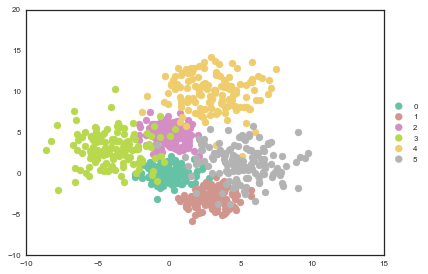

In [44]:
cmap = plt.get_cmap('Set2')
sb.set_context('paper')
sb.set_style('white')
colors = [cmap(XX) for XX in np.linspace(0,1,C)]
plt.figure()
for c in range(C):
    plt.scatter(X[c*N/C:(c+1)*N/C, 0], X[c*N/C:(c+1)*N/C, 1], color = colors[c], s=50, label= c)
plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))

In [45]:
from scipy.spatial.distance import cdist
D = cdist(X, X)

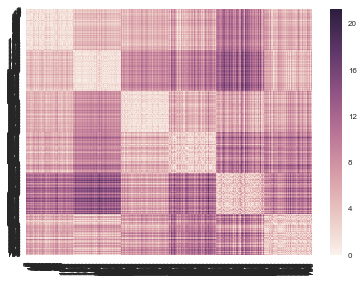

In [46]:
sb.heatmap(D)

In [85]:
### Extract K-neighbor graph from simlarity:
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(D, 10, mode='distance')
A = A + A.T
A[A>1]=1
K = A.T.dot(A)
Deg = np.diagflat(1.0/np.sqrt(K.diagonal()))
K = sc.sparse.csc_matrix(Deg.dot(K.todense().dot(Deg)))

In [86]:
Deg = np.diagflat(1.0/K.diagonal())

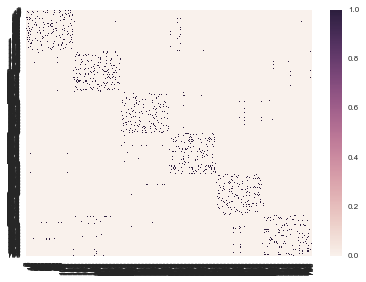

In [87]:
sb.heatmap(A.todense())

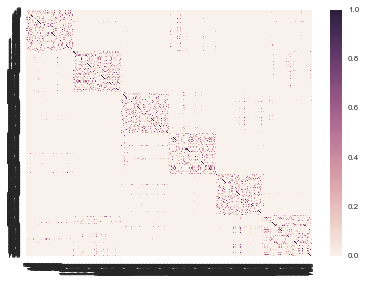

In [89]:
sb.heatmap(K.todense())

In [90]:
#### Run the procedure

import pandas as pd
import copy
import logging
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.spatial.distance import cdist
import scipy as sc
import sklearn as sk
import sys
import time

if True:
    ALPHA = 0.95
    TOL = 0.01
    MAXITERFISTA = 200
    MAXITERFISTA2 = 200
    logger = None
    n_nodes = K.shape[0]

    n_nodes = K.shape[0]
    I = np.eye(n_nodes)
    Y, pi, pi_prev = [np.eye(n_nodes)]*3
    evol_efficient_rank={}
    L = 2*sc.sparse.linalg.norm(K.power(2), 'fro')

    res = {}
    value_taken= {}
    t_k = 1
    conv_p, conv_q, conv_x = {}, {} , {}
    store_pi = {}

    for lambd0 in [0.001,0.01,0.1, 0.2, 0.3, 0.4,0.5,0.7,1.0,1.3,1.5, 2.0,3.0,4.0,5.0,7,10,50,100]:
        tic = time.time()

        pi_prev_old=pi_prev
        delta_pi=[]
        it = 0 
        converged =False
        print("Beginning l=%f"%(lambd0))
        lambd = 2*lambd0/ L
        B = pi_prev
        conv_p[lambd0], conv_q[lambd0], conv_x[lambd0] = {}, {} , {}
        evol_efficient_rank[lambd0] = [efficient_rank(pi_prev.T.dot(pi_prev))]
        m_tm1, nu_tm1 = np.zeros(B.shape),np.zeros(B.shape)
        inc  = 0
        value_taken[lambd0] = [1e18]   ### very big at first
        store_pi[lambd0] = [pi_prev]
        delta_val= []
        old_val = value_taken[lambd0][-1]
        
        while not converged:
            g_t =  (K.todense().dot(B) - K.todense())
            Z, time_taken, delta_x, delta_p, delta_q, dual, val = hcc_FISTA_denoise(K,
                                                                               B - 2.0/L * g_t,
                                                                               pi_prev,
                                                                               2.0/L*lambd0,
                                                                               alpha=ALPHA, 
                                                                               maxiterFISTA=MAXITERFISTA,
                                                                               eta=1.0,
                                                                               tol=TOL, 
                                                                               verbose=False,
                                                                               tol_projection=1e-2*TOL,
                                                                               logger=logger)
            
            pi_prev = Z
            if value_taken[lambd0][-1] < val:
                pi_prev = pi_prev_old
                value_taken[lambd0].append(value_taken[lambd0][-1])
                delta_val.append(0.0)
            else:
                value_taken[lambd0].append(val)
                delta_val.append(np.abs(val-old_val)/np.abs(old_val))
                old_val = val

            store_pi[lambd0].append(pi_prev)

            conv_p[lambd0][it] = delta_p
            conv_q[lambd0][it] = delta_q
            conv_x[lambd0][it] = delta_x
            t_kp1 = 0.5 * (1 + np.sqrt(1 + 4 * t_k**2))
            delta_pi.append(np.linalg.norm( pi_prev_old-pi_prev, 'fro')/np.linalg.norm( pi_prev_old, 'fro'))
            if delta_pi[-1] < TOL:
                inc += 1
            else:
                inc = 0
            converged = (delta_pi[-1] < TOL and inc > 10) or (it > MAXITERFISTA2)
            evol_efficient_rank[lambd0] += [efficient_rank(pi_prev.T.dot(pi_prev))]
            B = pi_prev + (t_k) / t_kp1 * (Z - pi_prev)\
                + (t_k - 1) / t_kp1 * (pi_prev - pi_prev_old)
            pi_prev_old = pi_prev
            t_k = t_kp1
            it +=1
            print('outer loop %i: conv: %f, rank: %f'%(it, delta_pi[-1], evol_efficient_rank[lambd0][-1]))
            print('--------------------------')

        print('--------------------------')
        print('--------------------------')
        print('--------------------------')
        toc = time.time()
        res[lambd0] = {'pi':pi_prev, 'convergence' : delta_pi,
                       'evolution_value': delta_val, 'time' : toc-tic,
                       'efficient_rank' : evol_efficient_rank[lambd0]}



Beginning l=0.001000
outer loop 1: conv: 0.000355, rank: 799.999995
--------------------------
outer loop 2: conv: 0.000360, rank: 799.999985
--------------------------
outer loop 3: conv: 0.000450, rank: 799.999959
--------------------------
outer loop 4: conv: 0.000536, rank: 799.999906
--------------------------
outer loop 5: conv: 0.000614, rank: 799.999804
--------------------------
outer loop 6: conv: 0.000688, rank: 799.999613
--------------------------
outer loop 7: conv: 0.000759, rank: 799.999287
--------------------------
outer loop 8: conv: 0.000827, rank: 799.998764
--------------------------
outer loop 9: conv: 0.000891, rank: 799.997980
--------------------------
outer loop 10: conv: 0.000952, rank: 799.996867
--------------------------
outer loop 11: conv: 0.001010, rank: 799.995364
--------------------------
--------------------------
--------------------------
--------------------------
Beginning l=0.010000
outer loop 1: conv: 0.002744, rank: 799.994542
--------------

outer loop 14: conv: 0.000000, rank: 271.400408
--------------------------
outer loop 15: conv: 0.000000, rank: 271.400408
--------------------------
outer loop 16: conv: 0.000000, rank: 271.400408
--------------------------
outer loop 17: conv: 0.000000, rank: 271.400408
--------------------------
outer loop 18: conv: 0.275843, rank: 286.558754
--------------------------
outer loop 19: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 20: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 21: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 22: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 23: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 24: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 25: conv: 0.000000, rank: 286.558754
--------------------------
outer loop 26: conv: 0.322975, rank: 286.351927
--------------------------
outer loop 27: conv: 0.00

outer loop 19: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 20: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 21: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 22: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 23: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 24: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 25: conv: 0.000000, rank: 164.768029
--------------------------
outer loop 26: conv: 0.000000, rank: 164.768029
--------------------------
--------------------------
--------------------------
--------------------------
Beginning l=0.500000
outer loop 1: conv: 0.652058, rank: 143.024527
--------------------------
outer loop 2: conv: 0.592313, rank: 147.811146
--------------------------
outer loop 3: conv: 0.627995, rank: 147.604830
--------------------------
outer loop 4: conv: 0.650077, rank: 139.495424
--------------------------
ou

outer loop 2: conv: 1.366606, rank: 201.604709
--------------------------
outer loop 3: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 4: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 5: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 6: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 7: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 8: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 9: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 10: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 11: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 12: conv: 0.000000, rank: 201.604709
--------------------------
outer loop 13: conv: 0.000000, rank: 201.604709
--------------------------
--------------------------
--------------------------
--------------------------
Beginning l=4.000000
outer 

In [91]:
2+2

4

# II. Stochastic Block Models

In [ ]:
def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = numpy.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


    G = nx.read_edgelist("hartford_drug.edgelist")

    # Extract largest connected component into graph H
    H = next(nx.connected_component_subgraphs(G))
    # Makes life easier to have consecutively labeled integer nodes
    H = nx.convert_node_labels_to_integers(H)
    # Create parititions with hierarchical clustering
    partitions = create_hc(H)
    # Build blockmodel graph
    BM = nx.quotient_graph(H, partitions, relabel=True)

    # Draw original graph
    pos = nx.spring_layout(H, iterations=100)
    plt.subplot(211)
    nx.draw(H, pos, with_labels=False, node_size=10)

# III. Nested Subcliques

### III. a. Simple ER structure





### III.b. More complex structure